In [1]:
import numpy as np
import numpy.random as nrd

import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier

# Exercise 13.7

Consider the application of nearest-neighbors to the “easy” and “hard” problems in the left panel of Figure 13.5.

1. Replicate the results in the left panel of Figure 13.5.

2. Estimate the misclassification errors using fivefold cross-validation, and compare the error rate curves to those in 1.

3. Consider an “AIC-like” penalization of the training set misclassification error. Specifically, add 2t/N to the training set misclassification error, where t is the approximate number of parameters N/r, r being the number of nearest-neighbors. Compare plots of the resulting penalized misclassification error to those in 1 and 2. Which method gives a better estimate of the optimal number of nearest-neighbors: cross-validation or AIC?

# Solution

Data generation,

In [2]:
def response_easy(X):

    N,_ = X.shape
    y = np.zeros(N)
    
    bool_1 = X[:,0] > 0.5
    y[bool_1] = 1
    
    return y

def response_hard(X):
    
    N,_ = X.shape
    y = np.zeros(N)
    
    bool_1 = np.sign((X[:,0] - 0.5)*(X[:,1] - 0.5)*(X[:,2] - 0.5)) > 0
    y[bool_1] = 1
    
    return y

In [3]:
p = 10
N_train = 100
N_test = 1000

# Input dataset
X_train = nrd.normal(size=(N_train,p))
X_test = nrd.normal(size=(N_test,p))

# Response (easy problem)
y_train_easy = response_easy(X_train)
y_test_easy = response_easy(X_test)

# Response (hard problem)
y_train_hard = response_hard(X_train)
y_test_hard = response_hard(X_test)

Visualizing the dataset separations,

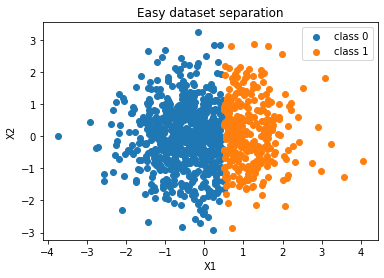

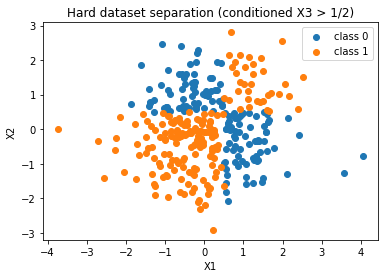

In [4]:
# Easy dataset
X_class0 = X_test[y_test_easy == 0]
X_class1 = X_test[y_test_easy == 1]

plt.scatter(X_class0[:,0],X_class0[:,1],label='class 0')
plt.scatter(X_class1[:,0],X_class1[:,1],label='class 1')
plt.title('Easy dataset separation')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()

# Hard dataset
X_class0 = X_test[np.logical_and(y_test_hard==0,X_test[:,2]>0.5)]
X_class1 = X_test[np.logical_and(y_test_hard==1,X_test[:,2]>0.5)]

plt.scatter(X_class0[:,0],X_class0[:,1],label='class 0')
plt.scatter(X_class1[:,0],X_class1[:,1],label='class 1')
plt.title('Hard dataset separation (conditioned X3 > 1/2)')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()

### Classification error for easy and hard dataset

Some useful functions for later,

In [5]:
# Compute the test error for different number of neighbours in K-NN
def NN_test_error_curve(X_train,y_train,X_test,y_test,nn_list):
    N_test,_ = X_test.shape

    misclass_error = []
    misclass_std_err = []
    for num in nn_list:

        # Fit the KNN model
        model = KNeighborsClassifier(n_neighbors=num)
        model.fit(X_train,y_train)

        # predict response for test set
        y_predict = model.predict(X_test)

        # Compute miscalssification rate and std error
        err = np.mean(y_predict != y_test)

        misclass_error.append(err)

    return misclass_error

# returns cross-validaiton split
def cross_validation_split(X,y,K):
    N,_ = X.shape
    delta = N//K
    
    data_CV = []
    
    for i in range(K):
        
        X_train = np.concatenate((X[:i*delta],X[(i+1)*delta:]))
        y_train = np.concatenate((y[:i*delta],y[(i+1)*delta:]))
        
        X_val = X[i*delta:(i+1)*delta]
        y_val = y[i*delta:(i+1)*delta]
        
        data_CV.append((X_train,y_train,X_val,y_val))
        
    return data_CV

# Cross- validation for K-NN, for different values of K
def NN_cross_validation(X,y,nn_list,K):

    validation_error = []
    validation_std_err = []

    for num in nn_list:
        misclass_error = []
        for X_train,y_train,X_val,y_val in cross_validation_split(X,y,K):

            # Fit the KNN model
            model = KNeighborsClassifier(n_neighbors=num)
            model.fit(X_train,y_train)

            # predict response for validation set
            y_predict = model.predict(X_val)

            # Compute miscalssification rate
            err = np.mean(y_predict != y_val)
            misclass_error.append(err)
        validation_error.append(np.mean(misclass_error))
        validation_std_err.append(np.std(misclass_error)/np.sqrt(K))

    return validation_error,validation_std_err

# AIC for estimating test error from training error, for K-NN with different K
def NN_AIC(X,y,nn_list):
    N,_ = X.shape

    misclass_error = []
    for num in nn_list:

        # Fit the KNN model
        model = KNeighborsClassifier(n_neighbors=num)
        model.fit(X,y)
        
        # Compute miscalssification rate and degrees of freedom
        y_predict = model.predict(X)
        err = np.mean(y_predict != y)
        dofs = N/num

        misclass_error.append(err + 2*dofs/N)

    return misclass_error

Test error, cross-validation, and AIC,

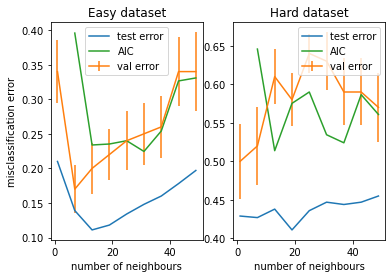

In [8]:
# List of different k for NN
min_k = 1
max_k = 50
delta_k = 6
nn_list = list(range(min_k,max_k,delta_k))

# Computing the error curves
error_easy = NN_test_error_curve(X_train,y_train_easy,X_test,y_test_easy,nn_list)
error_hard = NN_test_error_curve(X_train,y_train_hard,X_test,y_test_hard,nn_list)

# Estimating test error using cross-validation
K = 10
cv_easy, cv_SE_easy = NN_cross_validation(X_train,y_train_easy,nn_list,K)
cv_hard, cv_SE_hard = NN_cross_validation(X_train,y_train_hard,nn_list,K)

# Using AIC to estimate the test error
AIC_easy = NN_AIC(X_train,y_train_easy,nn_list)
AIC_hard = NN_AIC(X_train,y_train_hard,nn_list)

# for k=1 nn, we get AIC = 2, so lets get rid of that
AIC_easy = [None] + AIC_easy[1:]
AIC_hard = [None] + AIC_hard[1:]

# Showing the error curves
plt.subplot(1,2,1)

plt.plot(nn_list,error_easy,label='test error')
plt.errorbar(nn_list,cv_easy,yerr=cv_SE_easy,label='val error')
plt.plot(nn_list,AIC_easy,label='AIC')
plt.title('Easy dataset')
plt.ylabel('misclassification error')
plt.xlabel('number of neighbours')
plt.legend()

plt.subplot(1,2,2)

plt.plot(nn_list,error_hard,label='test error')
plt.errorbar(nn_list,cv_hard,yerr=cv_SE_hard,label='val error')
plt.plot(nn_list,AIC_hard,label='AIC')
plt.title('Hard dataset')
plt.xlabel('number of neighbours')
plt.legend()
plt.show()

- Cross-validation does not seems to do great in estimating the test error. In the easy case, the test error is withing the std error of CV, in the hard case no. However, the CV error in the hard case see,s to mimic more closely the test error curve (it monotonically increases, essentially).
- AIC does not work very well for a number of neigbours close to 1, since it massively overestiamte the test error!